# Implémentation d'un réseau CNN avec Keras

Dans ce script, nous avons pour objectif de construire un réseau convolutif CNN afin de démontrer les limites de ce type de réseau pour la classification de données frugales.

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from sklearn.utils import shuffle

## Premier réseau CNN

In [21]:
# Définition des hyperparamètres
batch_size = 64
epochs = 10
input_shape = (96, 96, 1)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [22]:
# Definition of the simplified CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Conv2D(128, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),

    Flatten(),
    Dense(1024, activation='relu'),
    # Dropout(0.5),
    Dense(128),
    Dense(10, activation='softmax')
])

model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 10, 128)      

In [15]:
# Custom function to extract category labels from file paths
def extract_category_label(file_path):
    category = os.path.split(os.path.dirname(file_path))[1]  # Extract category from parent directory name
    return category

In [24]:

# Load train, validation, and test data from CSV files
train_df = pd.read_csv('Split_Cargo_Bulk_Container/train.csv', header=None, names=["file_path"])
validation_df = pd.read_csv('Split_Cargo_Bulk_Container/validation.csv', header=None, names=["file_path"])
test_df = pd.read_csv('Split_Cargo_Bulk_Container/test.csv', header=None, names=["file_path"])

# Extract category labels from file paths
train_df['label'] = train_df['file_path'].apply(lambda x: x.split("\\")[0])
validation_df['label'] = validation_df['file_path'].apply(lambda x: x.split("\\")[0])
test_df['label'] = test_df['file_path'].apply(lambda x: x.split("\\")[0])

In [27]:
# Shuffle the data
train_df = shuffle(train_df)
validation_df = shuffle(validation_df)
test_df = shuffle(test_df)

In [28]:
# Show the first few rows of the train data
print(train_df.head())

                                              file_path           label
2686  Container Ship\ContainerShip_Visual_Cargo_x387...  Container Ship
956    Cargo\Cargo_Visual_Other Type_x25046_y966_vv.tif           Cargo
1962  Bulk Carrier\BulkCarrier_Visual_Cargo_x10069_y...    Bulk Carrier
1170       Cargo\Cargo_Visual_Cargo_x8848_y10802_vv.tif           Cargo
865       Cargo\Cargo_Visual_Cargo_x26646_y11053_vv.tif           Cargo


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Initialize the ImageDataGenerator for basic image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
image_dir = '../OpenSARShip/Categories/'

# Assuming your CSV files contain columns 'file_path' for the image paths and 'label' for the category labels
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

Found 3019 validated image filenames belonging to 3 classes.
Found 377 validated image filenames belonging to 3 classes.


c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


Found 379 validated image filenames belonging to 3 classes.


c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_df.shape[0] // batch_size)

Epoch 1/10
47/47 [==============================] - 64s 1s/step - loss: 0.9633 - accuracy: 0.5486 - val_loss: 0.7885 - val_accuracy: 0.6062
Epoch 2/10
47/47 [==============================] - 45s 877ms/step - loss: 0.7908 - accuracy: 0.6399 - val_loss: 0.7527 - val_accuracy: 0.6625
Epoch 3/10
47/47 [==============================] - 55s 1s/step - loss: 0.7562 - accuracy: 0.6529 - val_loss: 0.7581 - val_accuracy: 0.6625
Epoch 4/10
47/47 [==============================] - 43s 834ms/step - loss: 0.7053 - accuracy: 0.6843 - val_loss: 0.7678 - val_accuracy: 0.6562
Epoch 5/10
47/47 [==============================] - 52s 1s/step - loss: 0.6472 - accuracy: 0.7191 - val_loss: 0.6398 - val_accuracy: 0.7250
Epoch 6/10
47/47 [==============================] - 60s 1s/step - loss: 0.6324 - accuracy: 0.7272 - val_loss: 0.6391 - val_accuracy: 0.7281
Epoch 7/10
47/47 [==============================] - 46s 897ms/step - loss: 0.5711 - accuracy: 0.7601 - val_loss: 0.6983 - val_accuracy: 0.7156
Epoch 8/10


In [32]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_df.shape[0] // batch_size)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

5/5 [==============================] - 6s 319ms/step - loss: 0.8739 - accuracy: 0.6875
Test accuracy: 0.6875, Test loss: 0.8739288449287415


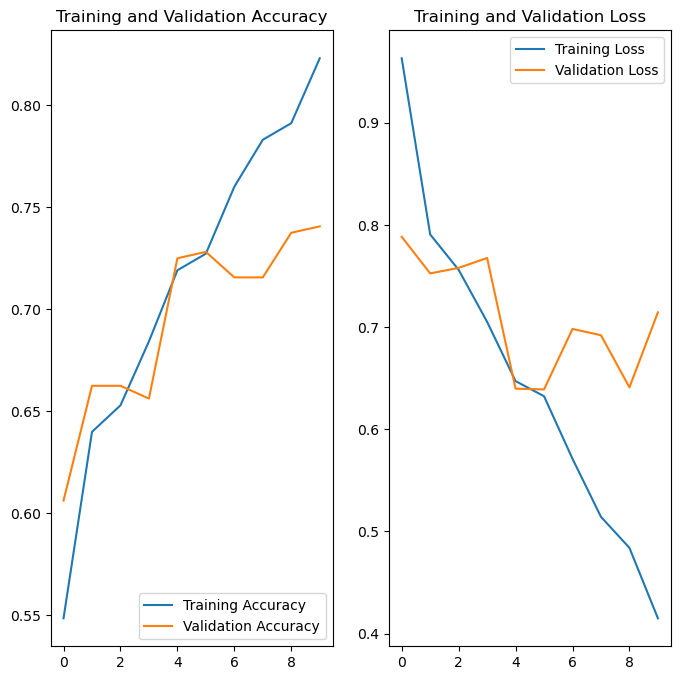

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
# import os

# # Custom function to extract category labels from file paths
# def extract_category_label(file_path):
#     category = os.path.split(os.path.dirname(file_path))[1]  # Extract category from parent directory name
#     return category

# # Load train, validation, and test data from CSV files
# train_df = pd.read_csv('Split_Cargo_Bulk_Container/train.csv')
# validation_df = pd.read_csv('Split_Cargo_Bulk_Container/validation.csv')
# test_df = pd.read_csv('Split_Cargo_Bulk_Container/test.csv')

# image_dir = '../OpenSARShip/Categories/'

# # Define data generators
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255
# )

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory=image_dir,
#     x_col='file_path',
#     y_col=None,  # No need to specify y_col here
#     target_size=(96, 96),
#     color_mode='grayscale',
#     class_mode=None,  # Do not specify class_mode for custom labels
#     batch_size=batch_size
# )

# train_generator.classes = train_df['file_path'].apply(extract_category_label)

# validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255
# )

# validation_generator = validation_datagen.flow_from_dataframe(
#     dataframe=validation_df,
#     directory=image_dir,
#     x_col='file_path',
#     y_col=None,  # No need to specify y_col here
#     target_size=(96, 96),
#     color_mode='grayscale',
#     class_mode=None,  # Do not specify class_mode for custom labels
#     batch_size=batch_size
# )

# validation_generator.classes = validation_df['file_path'].apply(extract_category_label)

# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=test_df,
#     directory=image_dir,
#     x_col='file_path',
#     y_col=None,  # No need to specify y_col here
#     target_size=(96, 96),
#     color_mode='grayscale',
#     class_mode=None,  # Do not specify class_mode for custom labels
#     batch_size=batch_size
# )

# test_generator.classes = test_df['file_path'].apply(extract_category_label)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=learning_rate), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# # Extract labels for train, validation, and test datasets
# train_labels = train_df['file_path'].apply(extract_category_label)
# validation_labels = validation_df['file_path'].apply(extract_category_label)
# test_labels = test_df['file_path'].apply(extract_category_label)

# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     epochs=epochs,
#     y=train_labels,  # Specify the target data for training
#     validation_y=validation_labels  # Specify the target data for validation
# )

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size, y=test_labels)  # Specify the target data for testing
# print(f'Test accuracy: {test_acc}')


Found 3019 validated image filenames.
Found 377 validated image filenames.
Found 379 validated image filenames.


TypeError: Model.fit() got an unexpected keyword argument 'validation_y'

#